In [1]:
import climpy.aeronet_utils as aeronet
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import netCDF4

__author__ = 'Sergey Osipov <Serega.Osipov@gmail.com>'

## IMPORTANT
First you have to set the path to the Aeronet data
If you don't have it yet, go to https://aeronet.gsfc.nasa.gov/
and click "Download All Sites" under Optical Depth or Inversion tabs. Extract them and specify this path below.

In [2]:
# Normally, I run scripts locally and on supercomputers and often root file path is different.
# To solve this problem I have special routine to deduce the correct environment.
from libs.file_path_utils import get_root_storage_path_on_hpc
aeronet.DATA_FILE_PATH_ROOT = get_root_storage_path_on_hpc() + '/Data/NASA/Aeronet/'

# You can simply copy-paste YOUR path in the next line
# aeronet.DATA_FILE_PATH_ROOT = os.path.expanduser('~') + '/Data/NASA/Aeronet/'

level = 15  # set the aeronet level 1.5 or 2.0
res = aeronet.ALL_POINTS  # set the temporal resolution, all points, daily, monthly
inv = False  # choose the product, direct ovservations (AOD) or inversion (INV)

## Basics
Get the AOD and plot it

Text(0, 0.5, 'Optical depth, ()')

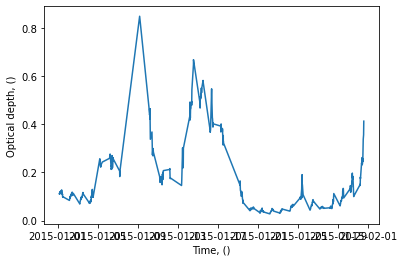

In [3]:
station='*Solar_Village*'  # Note the use of the wildcard
# use aux function to return ValueObject with the given diagnostic
aod_vo = aeronet.get_aod_diag(station, 'AOD_500nm', level=15, res=aeronet.ALL_POINTS)
# you can also apply time filter
time_range = (dt.datetime(2015, 1, 1), dt.datetime(2015, 2, 1))
aod_vo = aeronet.get_aod_diag(station, 'AOD_500nm', level=15, res=aeronet.ALL_POINTS,
                                      time_range=time_range)
# plot it
plt.figure()
plt.plot(aod_vo['time'], aod_vo['data'])
plt.xlabel('Time, ()')
plt.ylabel('Optical depth, ()')

Similarly, the size distribution dV/dlnr from the INV product can be read and plotted.
To normalize SD pass additional sd_normalization_raduis parameter.

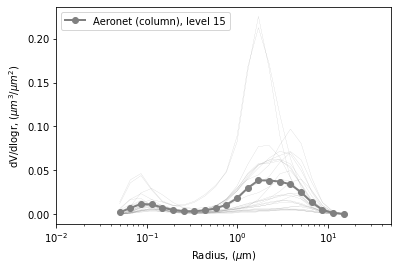

In [5]:
vo = aeronet.get_size_distribution(station, level=15, res=aeronet.ALL_POINTS,
                                   # sd_normalization_raduis=0.5,  # will normalize to 1 at 0.5 micron
                                      time_range=time_range)

plt.figure()
#plot individual SDs
plt.plot(vo['radii'], np.transpose(vo['data']), '-', color='gray', lw=0.1)
# and the mean
plt.plot(vo['radii'], np.mean(vo['data'], axis=0), '-o', color='gray', lw=2, label='Aeronet (column), level {}'.format(level))

plt.xscale('log')
plt.xlim([1 * 10 ** -2, 5 * 10 ** 1])
plt.xlabel('Radius, ($\mu $m)')
plt.ylabel('dV/dlogr, ($\mu m^3$/$\mu m^2$)')
plt.legend()

## Generic approach
The examples above are the wrappers around more generic utils (with decorators). They extract data from pandas object and put it into ValueObject (dictionary).

If you need more flexibility, you can use pandas directly, but you'll have to do each step manually or write your own routines.

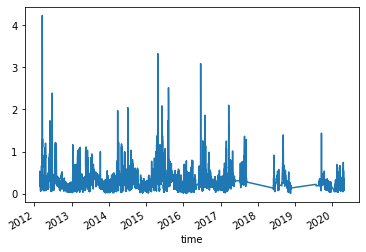

In [6]:
# build the file path to the station
fp = aeronet.get_station_file_path('*KAUST*', level=level, res=res, inv=inv)
# read all fields into pandas
df = aeronet.read_aeronet(fp)
# pick a diag from the list of available
var_key = df.columns[3]
# or assign it by hand if you know the label
var_key = 'AOD_1020nm'
# plot it
df[var_key].plot()

# Validation of WRF-Chem simulation

Suppose that you have a GCM model simulation and you want to validate simulated AOD or size distribution.
In this example I will use WRF-Chem. Since I can't upload NetCDF file (on github), some of the code will be commented out, but you should be able to adopt it easily.

In [3]:
# First, lets get the list of all Aeronet stations
stations = aeronet.get_all_stations_and_coordinates()
# overview
stations

,Site_Name,Longitude(decimal_degrees),Latitude(decimal_degrees),Elevation(meters)
0,Cuiaba,-56.070214,-15.555244,234.0
1,Alta_Floresta,-56.104453,-9.871339,277.0
2,Jamari,-63.068552,-9.199070,129.0
3,Tucson,-110.953003,32.233002,779.0
4,GSFC,-76.839833,38.992500,87.0
...,...,...,...,...
1523,EIN_TAMAR,35.389232,30.945667,-368.0
1524,Sofia_IEBAS,23.386800,42.653900,631.0
1525,Chiang_Dao,98.960900,19.454722,450.0
1526,Masdar_Institute_2,54.616600,22.417503,4.0


In [4]:
# define the model domain
# manually
domain = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])  # This is MENA region (Middle East and North Africa)
# or using WRF grid
# you have to put YOUR path here
wrf_file_path = get_root_storage_path_on_hpc() + '/Data/AirQuality/AQABA/chem_106/output/wrfout_d01_2017-07-20_00:00:00'
nc = netCDF4.Dataset(wrf_file_path)
lon = nc['XLONG'][0]  # my grid is stationary in time
lat = nc['XLAT'][0]  # sample it at time index 0
domain = Polygon([(np.min(lon), np.min(lat)), (np.min(lon), np.max(lat)), (np.max(lon), np.max(lat)), (np.max(lon), np.min(lat))])  # This is MENA region (Middle East and North Africa)

# filter stations within the domain
stations_inside_domain = pd.DataFrame(columns = stations.columns)
for index, row, in stations.iterrows():
    point = Point(row['Longitude(decimal_degrees)'], row['Latitude(decimal_degrees)'])
    # TODO: this test does not account for the map projection distortions
    if domain.contains(point):
        stations_inside_domain = stations_inside_domain.append(row, ignore_index=True)

# overview
stations_inside_domain

,Site_Name,Longitude(decimal_degrees),Latitude(decimal_degrees),Elevation(meters)
0,SEDE_BOKER,34.782222,30.855000,480.0
1,Xanthi,24.918950,41.146767,54.0
2,IMAA_Potenza,15.723700,40.601254,770.0
3,Bahrain,50.609267,26.208050,25.0
4,Solar_Village,46.397286,24.906933,764.0
...,...,...,...,...
98,Qena_SVU,32.747029,26.199924,75.7
99,Section-7_Platform,29.446600,44.545800,30.0
100,EIN_TAMAR,35.389232,30.945667,-368.0
101,Sofia_IEBAS,23.386800,42.653900,631.0


Plot the map of the domain, bounding polygon and the Aeronet stations

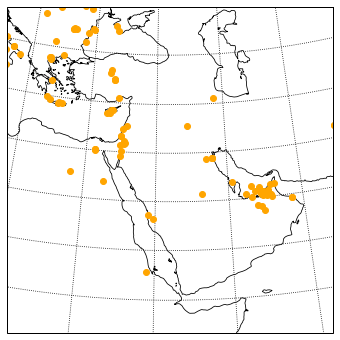

In [14]:
# import to work with WRF output
import wrf as wrf  # wrf-python library https://wrf-python.readthedocs.io/en/latest/
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as crs
import climpy.wrf_utils as wrf_utils
import climpy.grid_utils as grid

fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
cart_proj = wrf.get_cartopy(wrfin=nc)
ax = plt.axes(projection=cart_proj)
ax.coastlines('50m', linewidth=0.8)

ax.plot(stations_inside_domain['Longitude(decimal_degrees)'],
         stations_inside_domain['Latitude(decimal_degrees)'],
         color='orange', marker='o', linewidth=0,
         transform=crs.PlateCarree(),
         )

# Set the map bounds
ax.set_xlim(wrf.cartopy_xlim(wrfin=nc))
ax.set_ylim(wrf.cartopy_ylim(wrfin=nc))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")


Prepare model (WRF-Chem) data for comparison

In [9]:
wrf_time = wrf_utils.generate_netcdf_uniform_time_data(nc.variables['Times'])

In [12]:
station = stations_inside_domain.iloc[0]

In [13]:
station

Site_Name                     SEDE_BOKER
Longitude(decimal_degrees)       34.7822
Latitude(decimal_degrees)         30.855
Elevation(meters)                    480
Name: 0, dtype: object

In [8]:
# not all Aeronet stations will have the time coverage, find out which ones do
time_range = (np.min(wrf_time), np.max(wrf_time))
aod_vo = aeronet.get_aod_diag(station, 'AOD_500nm', level=15, res=aeronet.ALL_POINTS,
                                      time_range=time_range)

array([datetime.datetime(2017, 7, 20, 0, 0),
       datetime.datetime(2017, 7, 20, 1, 0),
       datetime.datetime(2017, 7, 20, 2, 0),
       datetime.datetime(2017, 7, 20, 3, 0),
       datetime.datetime(2017, 7, 20, 4, 0),
       datetime.datetime(2017, 7, 20, 5, 0),
       datetime.datetime(2017, 7, 20, 6, 0),
       datetime.datetime(2017, 7, 20, 7, 0),
       datetime.datetime(2017, 7, 20, 8, 0),
       datetime.datetime(2017, 7, 20, 9, 0),
       datetime.datetime(2017, 7, 20, 10, 0),
       datetime.datetime(2017, 7, 20, 11, 0),
       datetime.datetime(2017, 7, 20, 12, 0),
       datetime.datetime(2017, 7, 20, 13, 0),
       datetime.datetime(2017, 7, 20, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 20, 16, 0),
       datetime.datetime(2017, 7, 20, 17, 0),
       datetime.datetime(2017, 7, 20, 18, 0),
       datetime.datetime(2017, 7, 20, 19, 0),
       datetime.datetime(2017, 7, 20, 20, 0),
       datetime.datetime(2017, 7, 20, 21, 0)

In [16]:
station
yx_tuple, lon_p, lat_p, distance_error = grid.find_closest_grid_point(lon, lat, station['Longitude(decimal_degrees)'], station['Latitude(decimal_degrees)'])
# TODO: check that station is not too far, i.e. distance_error < some value, say 0.1

In [ ]:
# read OD profile (t, z, y, x)
# depending on the WRF version and namelist options, var name can be different and you have to save it
AOD = nc.variables['TAUAER3'][:, :, yx_tuple[0], yx_tuple[1]]

In [ ]:
AOD.shape


In [ ]:
vo = aeronet.get_aod_diag('*{}*'.format(station_df['Site_Name']), 'AOD_500nm', level=level, res=res)

In [35]:
vo.keys()

dict_keys(['data', 'time'])

## Alternative to getting list of stations from the WEB
You can loop through local files, but it is much slower and not recommend.
The advantage of this method is that you can filter station by time coverage.

In [ ]:
# First, lets get the list of all Aeronet stations
file_paths = aeronet.get_stations_file_path(aeronet.ALL_STATIONS, level=15, res=aeronet.ALL_POINTS, inv=False)


def spatial_filter(file_path):
    """
    Example of the spatial filter.
    Checks if the station is inside the polygon.
    :param file_path:
    :return:
    """
    df = aeronet.read_aeronet(file_path, only_head=True)
    point = Point(df['Site_Longitude(Degrees)'].iloc[0], df['Site_Latitude(Degrees)'].iloc[0])
    # MENA region
    polygon = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])
    return polygon.contains(point)


def spatial_and_temporal_filter(file_path):
    """
    Example of the spatial and temporal filter.
    Checks if the station is inside the polygon and if time coverage is appropriate.
    :param file_path:
    :return:
    """
    df = aeronet.read_aeronet(file_path, only_head=True)
    point = Point(df['Site_Longitude(Degrees)'].iloc[0], df['Site_Latitude(Degrees)'].iloc[0])
    # MENA region
    polygon = Polygon([(30, 12), (30, 30), (60, 30), (60, 12)])
    loc_flag = polygon.contains(point)
    time_flag = df.index[0] <= dt.datetime(2019, 1, 1)
    # TODO: we can also read last record and compare the right time interval as well

    return loc_flag and time_flag


# filter the stations inside the polygon (model domain bounds)
fps = aeronet.filter_stations(file_paths, spatial_filter)

# or add additional time filter (for example, simulations temporal extent)
fps = aeronet.filter_stations(file_paths, spatial_and_temporal_filter)

Similarly, you can loop through the file paths/stations

In [ ]:
for fp in fps:
    #print(fp)

    # get station name
    station = fp.split('/')[-1]
    # and get AOD
    aod_vo = aeronet.get_aod_diag(station, 'AOD_500nm', level=15, res=aeronet.ALL_POINTS)

    # or use generic reader
    df = aeronet.read_aeronet(fp)
